In [1]:
%%capture --no-display
!pip install opencv-python
!pip install torchmetrics
!pip install wandb

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision.io import read_image
import matplotlib.pyplot as plt
from PIL import Image
# pip install -q git+https://github.com/tensorflow/examples.git
from IPython.display import clear_output
import os
import random
import numpy as np
import cv2
import re
from tqdm.notebook import tqdm
from torchmetrics import Dice, JaccardIndex, Accuracy
import torch.nn.functional as F
from matplotlib.colors import ListedColormap
import torchvision.transforms.functional as tF
import subprocess

Load dataset 

In [3]:
# Note: the T/F order of FG and CG are flipped :(
def flip(path):
    # Regular expression to match the pattern and extract the True/False values
    pattern = r'(_True|_False)+(?=\.png$)'
    match = re.search(pattern, path)

    if match:
        # Extract the matched True/False substring
        true_false_str = match.group(0)

        # Split the substring into individual parts
        parts = true_false_str.split('_')

        # Filter out empty strings
        parts = [part for part in parts if part]

        if len(parts) >= 4:
            # Switch the center two values
            parts[1], parts[2] = parts[2], parts[1]

        # Reconstruct the True/False substring
        new_true_false_str = '_' + '_'.join(parts)

        # Replace the original True/False substring with the new one
        new_path = path[:match.start(0)] + new_true_false_str + path[match.end(0):]
        return new_path

In [4]:
# seperate paths
folders = [115, 116, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
          132, 133, 134, 135, 136, 102, 101, 103, 104, 105]

# Group tiles and masks by patient
patient_data = {folder: {'tiles': [], 'masks': []} for folder in folders}

for folder in tqdm(folders, position=0, leave=True):
    dataset_path = os.path.join("..", "..", "..", "..", "data", "UNet_Data_Bigger", str(folder))
    for file in sorted(os.listdir(dataset_path)):
        # ignoring masks
        if "tile" in file:
            # only keeping images with tumors
            if "True" not in file:
                continue

            # Extract the filename
            filename = f"{folder}_"+os.path.basename(file)
            extracted = "_".join(filename.split('_')[:3])+"_"

            # Specify the directory
            directory =  os.path.join("..", "..", "..", "..", "data", "UNet_Data_Bigger", "combined_masks_fixed")

            # Run the shell command in the specified directory
            result = subprocess.run(f'ls | grep {extracted}', capture_output=True, text=True, shell=True, cwd=directory)

            # Capture and split the output
            mask_path = result.stdout.splitlines()

            # check for anomalies
            if len(mask_path) != 1:
                print("Weird # of results")
                print("mask_path", mask_path)
                print("extracted", extracted)

            mask_path = os.path.join(directory, mask_path[0])

            # final tile and mask
            patient_data[folder]['tiles'].append(os.path.join(dataset_path, file))
            patient_data[folder]['masks'].append(mask_path)

# Seed for reproducibility
random.seed(42)

# Split patient IDs into train and validation sets
patient_ids = list(patient_data.keys())
random.shuffle(patient_ids)

train_size = int(0.8 * len(patient_ids))
train_patient_ids_temp = patient_ids[:train_size]
test_patient_ids = patient_ids[train_size:]

train_noval_size = int(0.8 * train_size)
train_patient_ids = train_patient_ids_temp[:train_noval_size]
val_patient_ids = train_patient_ids_temp[train_noval_size:]

# Function to get image paths for a list of patient IDs
def get_image_paths(patient_ids, patient_data):
    tiles = []
    masks = []
    for pid in patient_ids:
        tiles.extend(patient_data[pid]['tiles'])
        masks.extend(patient_data[pid]['masks'])
    return tiles, masks

# Get train and validation image paths
train_tiles, train_masks = get_image_paths(train_patient_ids, patient_data)
val_tiles, val_masks = get_image_paths(val_patient_ids, patient_data)
test_tiles, test_masks = get_image_paths(test_patient_ids, patient_data)

  0%|          | 0/25 [00:00<?, ?it/s]

Check that images look correct

In [5]:
def overlay(tiles, masks, index):
    image_path = tiles[index]
    mask_path = masks[index]

    # Open an image file
    image = Image.open(image_path)
    mask = Image.open(mask_path)

    # Convert image and mask to numpy arrays
    image_np = np.array(image)
    mask_np = np.array(mask)

    # Ensure mask is a single channel
    if mask_np.ndim == 3:
        mask_np = mask_np[..., 0]  # Take only one channel if it has multiple

    # Define color mapping for mask values 0-4
    colors = {
        0: [0, 0, 0],      # Black (no mask)
        1: [48, 255, 50],    # Grade 3
        2: [254, 22, 255],    # Grade 4 CG
        3: [255, 250, 20],    # Grade 4 FG
        4: [33, 255, 255],  # Grade 5
    }

    # Create an empty RGB mask (3 channels)
    mask_rgb = np.zeros((mask_np.shape[0], mask_np.shape[1], 3), dtype=np.uint8)

    # Apply the color mapping to create the RGB mask
    for value, color in colors.items():
        mask_rgb[mask_np == value] = color

    # Overlay the mask on the image with some transparency
    alpha = 0.5  # Transparency factor
    overlay = np.where(mask_rgb.any(axis=-1, keepdims=True), 
                       alpha * mask_rgb + (1 - alpha) * image_np[..., :3], 
                       image_np[..., :3]).astype(np.uint8)

    # Display the result
    plt.figure(figsize=(5, 5))
    plt.imshow(overlay)
    plt.axis('off')
    plt.title('Image with Mask Overlay')
    plt.show()

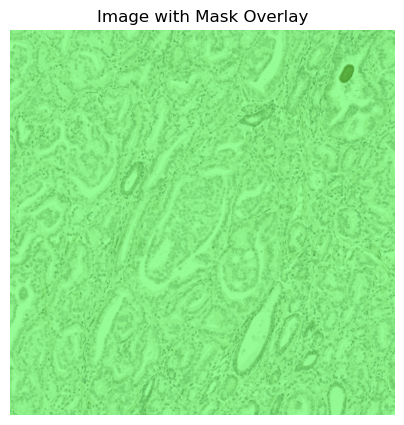

In [6]:
overlay(test_tiles, test_masks, 1)

Define UNet architecture

In [7]:
class UNet(nn.Module):
    def __init__(self, num_classes=5):
        super(UNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.bottleneck = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, num_classes, kernel_size=2, stride=2)
        )
        self.final_conv = nn.Conv2d(in_channels=num_classes, out_channels=num_classes, kernel_size=1)

    def forward(self, x):
        enc_features = self.encoder(x)
        bottleneck_features = self.bottleneck(enc_features)
        dec_features = self.decoder(bottleneck_features)
        x = self.final_conv(dec_features)
        return x

In [8]:
# from article https://ayushsojitra1.medium.com/understanding-and-implementing-u-net-architecture-622369538ced
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=5, features=[64, 128, 256, 512]):
        super(UNet, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature
        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]
            if x.shape != skip_connection.shape:
                x = tF.resize(x, size=skip_connection.shape[2:])
            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)
        return self.final_conv(x)

Dataset class

In [9]:
# after lunch problem: how to do augmentations when I don't know how many I'll do (or will I?)
class ClassBalancedDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None, augmentation=None, augmentations_per_class=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform
        self.augmentation = augmentation

        # Dictionary to store number of augmentations for each class
        if augmentations_per_class is None:
            self.augmentations_per_class = {
                'g5': 2,
                'g4_fg': 2,
                'g4_cg': 2,
                'other': 2
            }
        else:
            self.augmentations_per_class = augmentations_per_class

        # Calculate total number of items
        self.total_length = sum([self.augmentations_per_class[self.get_class(mask_path)] + 1 for mask_path in self.mask_paths])

    def __len__(self):
        return self.total_length

    def get_class(self, mask_path):
        pattern = r"_(True|False)"
        truth_values = re.findall(pattern, mask_path)

        if truth_values[3] == 'True':
            return 'g5'
        elif truth_values[2] == 'True':
            return 'g4_fg'
        elif truth_values[1] == 'True':
            return 'g4_cg'
        else:
            return 'other'

    def __getitem__(self, idx):
        current_idx = 0
        for original_idx, mask_path in enumerate(self.mask_paths):
            image_path = self.image_paths[original_idx]
            mask_class = self.get_class(mask_path)
            num_augmentations = self.augmentations_per_class[mask_class]
            total_images_for_this_file = num_augmentations + 1

            if current_idx + total_images_for_this_file > idx:
                augmentation_idx = idx - current_idx
                image = Image.open(image_path).convert("RGB")
                mask = Image.open(mask_path)

                if self.augmentation and augmentation_idx > 0:
                    # image = self.augmentation(image
                    # mask = self.augmentation(mask)
                    image, mask = self.augment(image, mask)

                if self.transform:
                    image = self.transform(image)
                    mask = self.transform(mask)

                return image, mask

            current_idx += total_images_for_this_file

        raise IndexError("Index out of range")

    def augment(self, image, mask):
        # random crop
        i, j, h, w=transforms.RandomCrop.get_params(image, output_size=(512, 512))
        image=tF.crop(image, i, j, h, w)
        mask=tF.crop(mask, i, j, h, w)

        # random rotation
        angle=transforms.RandomRotation.get_params([-30, 30])
        image=tF.rotate(image, angle)
        mask=tF.rotate(mask, angle)

        # random horizontal flip
        if random.random() > 0.5:
            image=tF.hflip(image)
            mask=tF.hflip(mask)

        # random vertical flip
        if random.random() > 0.5:
            image=tF.vflip(image)
            mask=tF.vflip(mask)

        return image, mask

In [10]:
# Define data transformations (resize, normalize, etc.)
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    # Add other transformations as needed
])

# augmentation = transforms.Compose([
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomVerticalFlip(),
#     transforms.RandomRotation(30),
# ])

# Create augmented dataset
dataset = ClassBalancedDataset(train_tiles, train_masks, transform=transform)
val_dataset = ClassBalancedDataset(val_tiles, val_masks, transform=transform)
test_dataset = ClassBalancedDataset(test_tiles, test_masks, transform=transform)

Check that data coming from dataset looks correct

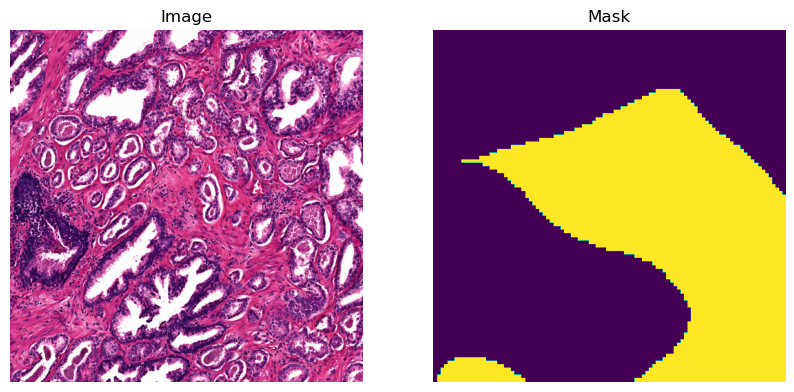

In [11]:
image, mask = dataset.__getitem__(0)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
# Display the first image in the first subplot
axs[0].imshow(np.transpose(image, (1, 2, 0)))
axs[0].set_title('Image')
axs[0].axis('off')  # Hide the axes

# Display the second image in the second subplot
axs[1].imshow(np.transpose(mask, (1, 2, 0)))
axs[1].set_title('Mask')
axs[1].axis('off')  # Hide the axes

# Show the figure
plt.show()

Initialize model and parameters

In [12]:
# Create data loader
batch_size = 16
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

# Create model instance and move it to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = UNet().to(device)


# Define loss function and optimizer
learning_rate = 0.01
class_weights = torch.tensor([1, 1, 5, 3, 4], dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

cuda


Define callbacks

In [13]:
# Callback base class
class Callback:
    def on_epoch_begin(self, epoch, logs=None):
        pass

    def on_epoch_end(self, epoch, logs=None):
        pass

    def on_batch_begin(self, batch, logs=None):
        pass

    def on_batch_end(self, batch, logs=None):
        pass

    def on_train_begin(self, logs=None):
        pass

    def on_train_end(self, logs=None):
        pass

In [14]:
class WandbCallback(Callback):
    def on_train_begin(self, logs=None):
        self.epoch_train_loss = []
        self.epoch_val_loss = []
        self.epoch_train_dice = []
        self.epoch_val_dice = []
        self.epoch_train_iou = []
        self.epoch_val_iou = []
        self.epoch_train_acc = []
        self.epoch_val_acc = []
        self.batch_train_loss = []

    def on_epoch_end(self, epoch, logs=None):
        self.epoch_train_loss.append(logs.get('loss'))
        self.epoch_val_loss.append(logs.get('val_loss'))

        # Log to wandb
        wandb.log({
            "epoch": epoch,
            "train_loss": logs.get('loss'),
            "val_loss": logs.get('val_loss'),
            "train_dice": logs.get('dice'),
            "val_dice": logs.get('val_dice'),
            "train_iou": logs.get('iou'),
            "val_iou": logs.get('val_iou'),
            "train_accuracy": logs.get('accuracy'),
            "val_accuracy": logs.get('val_accuracy')
        })

    # def on_batch_end(self, batch, logs=None):
    #     self.batch_train_loss.append(logs.get('batch_loss'))
    #     # Log to wandb
    #     wandb.log({
    #         "batch": batch,
    #         "batch_loss": logs.get('batch_loss')
    #     })

Training loop

In [15]:
# log into visualizing software
import wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: sarah-i-rubenstein (sarah-i-rubenstein-Medical College of Wisconsin). Use `wandb login --relogin` to force relogin


True

In [16]:
# create run
wandb.init(
    project="copilot-unet",
    config={
        "batch_size": batch_size,
        "learning_rate": learning_rate,
        "criterion": "CrossEntropyLoss (weighted swapping FG/CG weights)",
        "optimizer": "Adam",
        "dataset": "fixed class balancing data",
        "model": "from medium article"
    },
    settings=wandb.Settings(silent=True)
)

In [17]:
def train(model, criterion, optimizer, dataloader, val_dataloader, num_epochs, callbacks=[]):
    # Define the metrics
    dice_metric = Dice(num_classes=5, average='macro', ignore_index=0).to('cuda')
    iou_metric = JaccardIndex(num_classes=5, average='macro', task="multiclass", ignore_index=0).to('cuda')
    accuracy_metric = Accuracy(num_classes=5, average='macro', task="multiclass").to('cuda')

    logs = {}

    for callback in callbacks:
        callback.on_train_begin(logs)

    # try:
    for epoch in range(num_epochs):
        for callback in callbacks:
            callback.on_epoch_begin(epoch, logs)

        model.train()
        running_loss = 0.0
        i = 0
        for images, masks in tqdm(dataloader, position=0, leave=True):
            i += 1
            for callback in callbacks:
                callback.on_batch_begin(i, logs)

            # Move images and masks to GPU if available
            images = images.to(device)
            masks = masks.to(device)
            masks = masks.squeeze(1)

            # Forward pass
            outputs = model(images)

            # Debug: Check the shapes and values of outputs and masks
            assert outputs.shape[2:] == masks.shape[1:], f"Shape mismatch: {outputs.shape} vs {masks.shape}"
            assert torch.all(masks >= 0) and torch.all(masks < 5), "Masks contain invalid values"

            loss = criterion(outputs, masks.long())

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Get predicted class probabilities and predicted classes
            preds = torch.argmax(outputs, dim=1)

            # Update metrics
            dice_metric.update(preds, masks.int())
            iou_metric.update(preds, masks.int())
            accuracy_metric.update(preds, masks.int())

            running_loss += loss.item()

            logs['batch_loss'] = loss.item()
            for callback in callbacks:
                callback.on_batch_end(i, logs)

        epoch_loss = running_loss / len(dataloader)
        logs['loss'] = epoch_loss

        # Compute metrics
        dice_score = dice_metric.compute()
        iou_score = iou_metric.compute()
        accuracy_score = accuracy_metric.compute()
        logs['dice'] = dice_score
        logs['iou'] = iou_score
        logs['accuracy'] = accuracy_score

        # Reset metrics for the next epoch
        dice_metric.reset()
        iou_metric.reset()
        accuracy_metric.reset()

        # Validation step
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, masks in tqdm(val_dataloader, position=0, leave=True):
                images, masks = images.to(device), masks.to(device)
                masks = masks.squeeze(1)
                outputs = model(images)

                # Resize outputs to match mask size
                # outputs = transforms.Resize((100, 100))(outputs)
                loss = criterion(outputs, masks.long())
                val_loss += loss.item()

                # Get predicted class probabilities and predicted classes
                preds = torch.argmax(outputs, dim=1)

                # Update metrics
                dice_metric.update(preds, masks.int())
                iou_metric.update(preds, masks.int())
                accuracy_metric.update(preds, masks.int())

        # Compute validation metrics
        val_dice_score = dice_metric.compute()
        val_iou_score = iou_metric.compute()
        val_accuracy_score = accuracy_metric.compute()
        logs['val_dice'] = val_dice_score
        logs['val_iou'] = val_iou_score
        logs['val_accuracy'] = val_accuracy_score

        # Reset metrics for the next epoch
        dice_metric.reset()
        iou_metric.reset()
        accuracy_metric.reset()

        val_loss /= len(val_dataloader)
        logs['val_loss'] = val_loss

        for callback in callbacks:
            callback.on_epoch_end(epoch, logs)

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}")

        # save model after each epoch
        try:
            save_path = os.path.join("saved_models", f'Copilot_UNet_epoch_{epoch}.pth')
            torch.save(model.state_dict(), save_path)
        except:
            print("Model save failed")

    # except:
    #     print("Training stopped early")

    for callback in callbacks:
        callback.on_train_end(logs)

In [ ]:
%%wandb
train(model, criterion, optimizer, dataloader, val_dataloader, num_epochs=50, callbacks=[WandbCallback()])

  0%|          | 0/2065 [00:00<?, ?it/s]

/opt/conda/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:84.)
  return F.conv2d(input, weight, bias, self.stride,
/opt/conda/lib/python3.11/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


  0%|          | 0/327 [00:00<?, ?it/s]

Epoch [1/50], Loss: 1.1384, Val Loss: 1.0464


  0%|          | 0/2065 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

Epoch [2/50], Loss: 1.0216, Val Loss: 0.9064


  0%|          | 0/2065 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

Epoch [3/50], Loss: 0.9416, Val Loss: 1.1359


  0%|          | 0/2065 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

Epoch [4/50], Loss: 0.8813, Val Loss: 1.1308


  0%|          | 0/2065 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

Epoch [5/50], Loss: 0.8394, Val Loss: 1.1016


  0%|          | 0/2065 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

Epoch [6/50], Loss: 0.8059, Val Loss: 1.1943


  0%|          | 0/2065 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

Epoch [7/50], Loss: 0.7844, Val Loss: 0.9904


  0%|          | 0/2065 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

Epoch [8/50], Loss: 0.7614, Val Loss: 0.9764


  0%|          | 0/2065 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

Epoch [9/50], Loss: 0.7366, Val Loss: 1.1421


  0%|          | 0/2065 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

Epoch [10/50], Loss: 0.7127, Val Loss: 0.7918


  0%|          | 0/2065 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

Epoch [11/50], Loss: 0.6932, Val Loss: 0.8455


  0%|          | 0/2065 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

Epoch [12/50], Loss: 0.6650, Val Loss: 1.1278


  0%|          | 0/2065 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

Epoch [13/50], Loss: 0.6394, Val Loss: 0.8435


  0%|          | 0/2065 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

Epoch [14/50], Loss: 0.6082, Val Loss: 1.0282


  0%|          | 0/2065 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

Epoch [15/50], Loss: 0.5671, Val Loss: 1.0081


  0%|          | 0/2065 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

Epoch [16/50], Loss: 0.5210, Val Loss: 0.9466


  0%|          | 0/2065 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

Epoch [17/50], Loss: 0.4729, Val Loss: 1.1217


  0%|          | 0/2065 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

Epoch [18/50], Loss: 0.4150, Val Loss: 1.1381


  0%|          | 0/2065 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

Epoch [19/50], Loss: 0.3600, Val Loss: 1.0883


  0%|          | 0/2065 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

Epoch [20/50], Loss: 0.3164, Val Loss: 1.3627


  0%|          | 0/2065 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

Epoch [21/50], Loss: 0.2764, Val Loss: 1.3605


  0%|          | 0/2065 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

Epoch [22/50], Loss: 0.2381, Val Loss: 1.5972


  0%|          | 0/2065 [00:00<?, ?it/s]

Check what the hell is going on

In [ ]:
# Instantiate the model
loaded_model = UNet()

# Load the state dictionary
state_dict = torch.load("./saved_models/Copilot_UNet_epoch_12.pth")

# Load the state dictionary into the model
loaded_model.load_state_dict(state_dict)

# Set the model to evaluation mode
loaded_model.eval()

Show one single prediction

In [ ]:
def plot_prediction(image, mask, pred):
    # Define the custom colors for the values 0 to 4
    # colors = {0: '#1f77b4', 1: '#ff7f0e', 2: '#2ca02c', 3: '#d62728', 4: '#9467bd'}
    # navy, green, fuscia, yellow, cyan
    colors = {0: '#1f77b4', 1: '#30FF32', 2: '#FE16FF', 3: '#FFFA14', 4: '#21FFFF'}

    # Function to apply colors to the mask
    def apply_colors(array, colors):
        colored_array = np.zeros(array.shape + (3,))
        for value, color in colors.items():
            colored_array[array == value] = np.array(list(int(color[i:i+2], 16) for i in (1, 3, 5))) / 255.0
        return colored_array

    # Create a figure and axis to plot the images
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Move tensors to CPU and convert to numpy arrays
    image = image.detach().cpu().numpy()
    mask = mask.detach().cpu().numpy()
    pred = pred.detach().cpu().numpy()

    # Plot the first image
    axes[0].imshow(np.transpose(image, (1, 2, 0)))
    axes[0].axis('off')  # Hide the axis
    axes[0].set_title('Image')

    # Plot the second image (mask)
    if mask.ndim == 3:
        mask_channel = mask[0]  # Select the first channel if the mask is 3D
    else:
        mask_channel = mask  # Use the mask directly if it's already 2D
    colored_mask = apply_colors(mask_channel, colors)
    axes[1].imshow(colored_mask)
    axes[1].axis('off')  # Hide the axis
    axes[1].set_title('Mask')

    # Plot the third image (prediction)
    if pred.ndim == 3:
        pred_channel = pred[0]  # Select the first channel if the prediction is 3D
    else:
        pred_channel = pred  # Use the prediction directly if it's already 2D
    colored_pred = apply_colors(pred_channel, colors)
    axes[2].imshow(colored_pred)
    axes[2].axis('off')  # Hide the axis
    axes[2].set_title('Prediction')

    # Display the images
    plt.show()

In [ ]:
# Example prediction (replace `input_tensor` with your actual input tensor)
with torch.no_grad():
    for images, masks in test_dataloader:
        images, masks = images.to(device), masks.to(device)

        output = model(images)
        # Note: output is 512x512... why?
        print("output shape", output.shape)

        # Get predicted class probabilities and predicted classes
        preds = torch.argmax(output, dim=1)
        print("preds shape", preds.shape)

        for i in range(4):
            plot_prediction(images[i], masks[i], preds[i])

Get formal metrics from the UNet and test data

In [ ]:
# Define the metrics
dice_metric = Dice(num_classes=5, average='macro', ignore_index=0).to('cuda')
iou_metric = JaccardIndex(num_classes=5, average='macro', task="multiclass", ignore_index=0).to('cuda')
accuracy_metric = Accuracy(num_classes=5, average='macro', task="multiclass").to('cuda')

with torch.no_grad():
    running_loss = 0.0
    for images, masks in tqdm(test_dataloader, position=0, leave=True):
        images, masks = images.to(device), masks.to(device)
        masks = masks.squeeze(1)

        output = model(images)

        loss = criterion(output, masks.long())

        preds = torch.argmax(output, dim=1)

        dice_metric.update(preds, masks.int())
        iou_metric.update(preds, masks.int())
        accuracy_metric.update(preds, masks.int())

        running_loss += loss.item()

    test_loss = running_loss / len(test_dataloader)

    # Compute metrics
    dice_score = dice_metric.compute()
    iou_score = iou_metric.compute()
    accuracy_score = accuracy_metric.compute()

    print("Test loss:", test_loss)
    print("Test dice:", dice_score)
    print("Test iou:", iou_score)
    print("Test accuracy:", accuracy_score)